In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from tensorflow import keras

### Load Base Model

In [3]:
base_model = keras.applications.InceptionV3(
                    weights='imagenet',
                    input_shape=(224, 224, 3),
                    include_top=False)

2022-12-04 13:32:43.739412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 13:32:43.740505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 13:32:44.048222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 13:32:44.049084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 13:32:44.049987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 1s 0us/step


In [4]:
# Freeze base model
base_model.trainable = False

### Add layers to model

In [5]:
inputs = keras.Input(shape = (224, 224, 3))

x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)

outputs = keras.layers.Dense(6, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 22,854,950
Trainable params: 1,052,166
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              metrics = keras.metrics.CategoricalAccuracy())

### Augment the data

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)

test_gen = ImageDataGenerator(samplewise_center=True)

In [9]:
train = train_gen.flow_from_directory(
    '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")


test = test_gen.flow_from_directory(
    '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical")

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [10]:
train.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

### Inspect the data

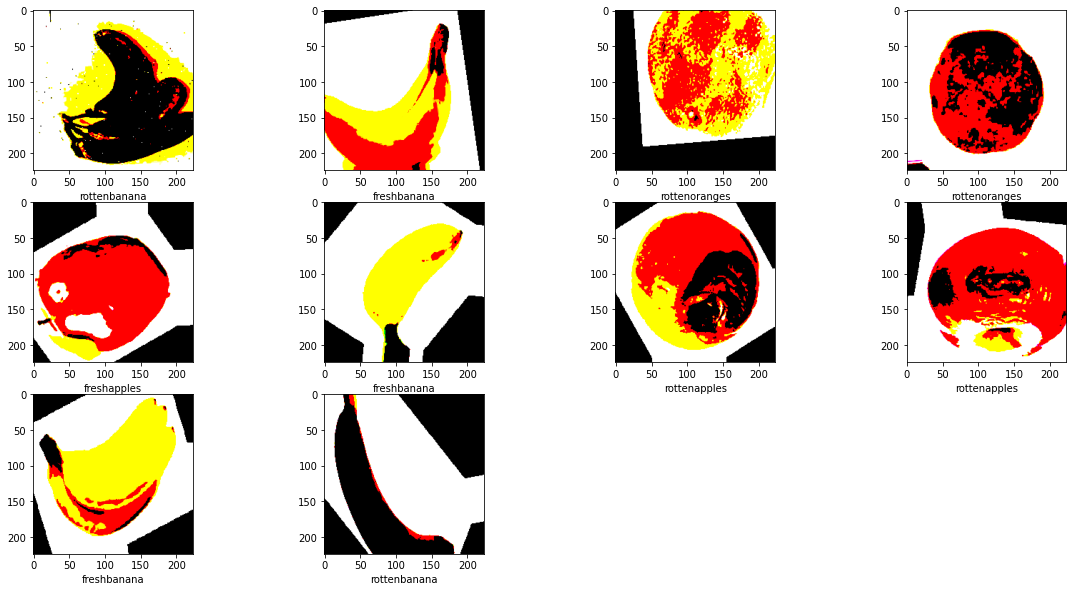

In [11]:
import matplotlib.pyplot as plt
# Encode the classes
classes = train.class_indices
classes = {indx: c for c, indx in classes.items()}


#PLotting some images 
images, labels=train.next()
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    #plt.axis('off')
    plt.xlabel(classes[np.argmax(labels[i])])

### Fitting the model

In [12]:
callbacks = keras.callbacks.EarlyStopping(patience = 2, monitor='val_loss')


model.fit(train,
          validation_data = test,
          steps_per_epoch = train.samples/train.batch_size,
          validation_steps= test.samples/test.batch_size,
          epochs=8,
          callbacks= [callbacks])

2022-12-04 13:33:07.068394: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2022-12-04 13:33:13.639964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


340/340 [==============================] - 363s 1s/step - loss: 16.7075 - categorical_accuracy: 0.3768 - val_loss: 2.5052 - val_categorical_accuracy: 0.4807
Epoch 2/8
340/340 [==============================] - 206s 606ms/step - loss: 2.0860 - categorical_accuracy: 0.4762 - val_loss: 1.2746 - val_categorical_accuracy: 0.5315
Epoch 3/8
340/340 [==============================] - 205s 602ms/step - loss: 1.2551 - categorical_accuracy: 0.5389 - val_loss: 1.0049 - val_categorical_accuracy: 0.6294
Epoch 4/8
340/340 [==============================] - 204s 600ms/step - loss: 1.1394 - categorical_accuracy: 0.5788 - val_loss: 1.0449 - val_categorical_accuracy: 0.5986
Epoch 5/8
340/340 [==============================] - 210s 617ms/step - loss: 1.0819 - categorical_accuracy: 0.5994 - val_loss: 1.1120 - val_categorical_accuracy: 0.5574


### Fine tune all layers of the model

In [13]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
model.fit(train,
          validation_data= test,
          steps_per_epoch= train.samples/train.batch_size,
          validation_steps= test.samples/test.batch_size,
          epochs=5)

Epoch 1/5
340/340 [==============================] - 234s 659ms/step - loss: 1.0451 - categorical_accuracy: 0.7164 - val_loss: 0.2032 - val_categorical_accuracy: 0.9733
Epoch 2/5
340/340 [==============================] - 228s 668ms/step - loss: 0.1662 - categorical_accuracy: 0.9695 - val_loss: 0.0362 - val_categorical_accuracy: 0.9948
Epoch 3/5
340/340 [==============================] - 221s 647ms/step - loss: 0.0638 - categorical_accuracy: 0.9864 - val_loss: 0.0158 - val_categorical_accuracy: 0.9970
Epoch 4/5
340/340 [==============================] - 218s 640ms/step - loss: 0.0415 - categorical_accuracy: 0.9913 - val_loss: 0.0085 - val_categorical_accuracy: 0.9985
Epoch 5/5
340/340 [==============================] - 217s 636ms/step - loss: 0.0268 - categorical_accuracy: 0.9945 - val_loss: 0.0042 - val_categorical_accuracy: 0.9996


### Evaluating

In [15]:
model.evaluate(test, steps= test.samples/test.batch_size)

84/84 [==============================] - 18s 216ms/step - loss: 0.0042 - categorical_accuracy: 0.9996


[0.004155222792178392, 0.9996293783187866]

### Make a pipline for easy use

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image as image_utils


def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)
    


def pipe_line(image_path): 
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    final_pred = classes[np.argmax(preds)]
    return final_pred

'freshbanana'

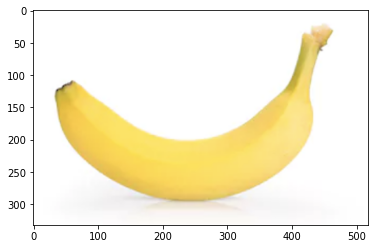

In [17]:
path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/Screen Shot 2018-06-12 at 10.00.37 PM.png'
pipe_line(path)